<a href="https://colab.research.google.com/github/shreya-ganiga-datasci/Toxic-content-classification-using-machine-learning-and-deep-learning/blob/main/TOXIC_CONTENT_CLASSIFICATION_USING_MACHINE_LEARNING_AND_DEEP_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Overview**

The rapid growth of online platforms has led to a rise in toxic, offensive, and harmful comments. Identifying and filtering such content is crucial for ensuring safe and respectful digital interactions.
This project focuses on building and comparing multiple Machine Learning (ML) and Deep Learning (DL) models to automatically classify text as toxic or non-toxic.

**Step 0 — install & imports**

In [2]:
# imports
import os, re, joblib, numpy as np, pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# tensorflow for CNN
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

print("Imports ready. cwd:", os.getcwd())


Imports ready. cwd: /content


**Step 1 — load the dataset**

In [4]:
from google.colab import files
uploaded = files.upload()


Saving RacismDetectionDataSet.csv to RacismDetectionDataSet.csv


In [6]:

FNAME = "RacismDetectionDataSet.csv"
df = pd.read_csv(FNAME)

# Quick checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Shape: (1999, 2)
Columns: ['Comment', 'Label']
                                             Comment  Label
0  i was born a racist and I will die a racist I ...      1
1                      bitch nigga miss me with that      1
2  if you aint bout that murder game pussy nigga ...      1
3  gay niggas couldnt wait to act like bitches to...      1
4  why deos a gorilla always have a frown because...      1


In [19]:
print(df.columns)
print(df.head())


Index(['Comment', 'Label', 'Clean'], dtype='object')
                                             Comment  Label  \
0  i was born a racist and I will die a racist I ...      1   
1                      bitch nigga miss me with that      1   
2  if you aint bout that murder game pussy nigga ...      1   
3  gay niggas couldnt wait to act like bitches to...      1   
4  why deos a gorilla always have a frown because...      1   

                                               Clean  
0  i was born a racist and i will die a racist i ...  
1                      bitch nigga miss me with that  
2  if you aint bout that murder game pussy nigga ...  
3  gay niggas couldnt wait to act like bitches to...  
4  why deos a gorilla always have a frown because...  


**Step 1B: Exploratory Data Analysis (EDA) with Graphs**

/tmp/ipython-input-3410469348.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Label", data=df, palette="Set2")


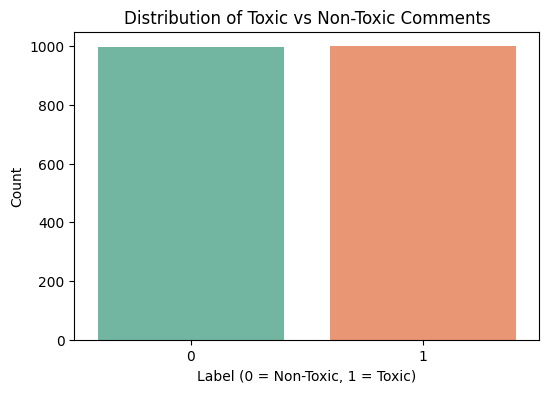

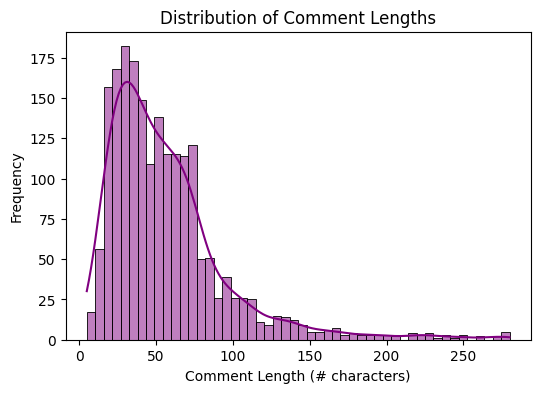

/tmp/ipython-input-3410469348.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Label", y="comment_length", data=df, palette="Set1")


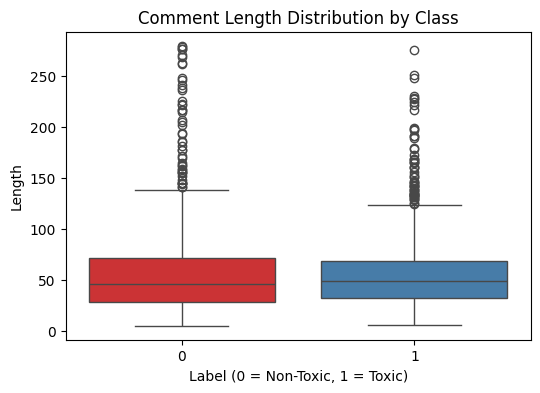

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of toxic vs non-toxic
plt.figure(figsize=(6,4))
sns.countplot(x="Label", data=df, palette="Set2")
plt.title("Distribution of Toxic vs Non-Toxic Comments")
plt.xlabel("Label (0 = Non-Toxic, 1 = Toxic)")
plt.ylabel("Count")
plt.show()

# Comment length analysis
df["comment_length"] = df["Comment"].astype(str).apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df["comment_length"], bins=50, kde=True, color="purple")
plt.title("Distribution of Comment Lengths")
plt.xlabel("Comment Length (# characters)")
plt.ylabel("Frequency")
plt.show()

# Average length per class
plt.figure(figsize=(6,4))
sns.boxplot(x="Label", y="comment_length", data=df, palette="Set1")
plt.title("Comment Length Distribution by Class")
plt.xlabel("Label (0 = Non-Toxic, 1 = Toxic)")
plt.ylabel("Length")
plt.show()


**Step 2 — define consistent cleaning (use raw regex strings)**

In [7]:
def remove_pattern(text, pattern):
    return re.sub(pattern, "", text)

def clean_text(t):
    if not isinstance(t, str):
        return ""
    t = remove_pattern(t, r"@[\w_]+")                                    # mentions
    t = remove_pattern(t, r"#[\w_]+")                                    # hashtags
    t = remove_pattern(t, r"&[\w_]+")                                    # &words
    t = remove_pattern(t, r"(?:(?:https?|ftp):\/\/|www\.)\S+")           # urls
    t = re.sub(r"[^a-zA-Z#]", " ", t)                                    # keep letters, replace others with space
    t = re.sub(r"\s+", " ", t).strip().lower()
    return t

# test:
examples = ["You are BAE!", "@user check http://test.com", "RAPE is a crime", "cruel"]
print([(ex, clean_text(ex)) for ex in examples])


[('You are BAE!', 'you are bae'), ('@user check http://test.com', 'check'), ('RAPE is a crime', 'rape is a crime'), ('cruel', 'cruel')]


**Step 3 — build cleaned dataframe & check labels**

In [8]:
# adapt column names if needed
if 'Comment' not in df.columns or 'Label' not in df.columns:
    raise ValueError("Dataset must have 'Comment' and 'Label' columns")

df = df.dropna(subset=['Comment', 'Label']).reset_index(drop=True)
df['Label'] = df['Label'].astype(int)           # ensure ints
df['Clean'] = df['Comment'].apply(clean_text)
df = df[df['Clean'].str.strip() != ""].reset_index(drop=True)   # drop empty cleaned lines

print("After cleaning shape:", df.shape)
print("Label counts:\n", df['Label'].value_counts())
print(df[['Comment','Clean','Label']].head(6))


After cleaning shape: (1999, 3)
Label counts:
 Label
1    1000
0     999
Name: count, dtype: int64
                                             Comment  \
0  i was born a racist and I will die a racist I ...   
1                      bitch nigga miss me with that   
2  if you aint bout that murder game pussy nigga ...   
3  gay niggas couldnt wait to act like bitches to...   
4  why deos a gorilla always have a frown because...   
5  fuck niggers, faggots, chinks sand niggers and...   

                                               Clean  Label  
0  i was born a racist and i will die a racist i ...      1  
1                      bitch nigga miss me with that      1  
2  if you aint bout that murder game pussy nigga ...      1  
3  gay niggas couldnt wait to act like bitches to...      1  
4  why deos a gorilla always have a frown because...      1  
5  fuck niggers faggots chinks sand niggers and e...      1  


**Step 4 — split data (train / val / test)**

In [9]:
X = df['Clean'].tolist()
y = df['Label'].tolist()

# first split test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# then split train/val from temp (val = 20% of remaining => 0.2 * 0.8 = 0.16 overall)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

print("Sizes -> train:", len(X_train), "val:", len(X_val), "test:", len(X_test))


Sizes -> train: 1279 val: 320 test: 400


**Step 5 — vectorize for classical ML (TF-IDF with uni+bi-grams)**

In [10]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.9, token_pattern=r"(?u)\b\w\w+\b")
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (1279, 10126) (320, 10126) (400, 10126)


**Step 6 — helper: metric function & threshold tuning**

We’ll use F1 as main metric; also a helper to tune thresholds for probabilistic models.


In [11]:
from sklearn.metrics import classification_report

def print_metrics(name, y_true, y_pred):
    print(f"=== {name} ===")
    print(classification_report(y_true, y_pred, digits=4))

def tune_threshold(model, X_val_vec, y_val, search=np.linspace(0.3,0.7,41)):
    # model should have predict_proba
    probs = model.predict_proba(X_val_vec)[:,1]
    best, best_thr = -1, 0.5
    for thr in search:
        preds = (probs >= thr).astype(int)
        f = f1_score(y_val, preds)
        if f > best:
            best, best_thr = f, thr
    return best_thr, best


**Step 7 — train classical models (RandomForest, SVM, Naive Bayes, KNN)**

We’ll train RF, SVM (calibrated to get probabilities), NB, and KNN. For RF & KNN (expensive on sparse), we'll reduce TF-IDF via TruncatedSVD to dense vectors.

In [12]:
# 7A: Prepare SVD reduction for RF and KNN (safe n_components)
n_components = min(200, X_train_tfidf.shape[1]-1, X_train_tfidf.shape[0]-1)
if n_components <= 0:
    n_components = min(50, X_train_tfidf.shape[0]-1)
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd   = svd.transform(X_val_tfidf)
X_test_svd  = svd.transform(X_test_tfidf)
print("SVD shape:", X_train_svd.shape)

# 7B: Random Forest (on SVD dense)
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced", n_jobs=-1)
rf.fit(X_train_svd, y_train)
rf_pred = rf.predict(X_val_svd)
print_metrics("RandomForest (val)", y_val, rf_pred)

# 7C: LinearSVC calibrated -> gives predict_proba
svc_base = LinearSVC(class_weight="balanced", max_iter=5000)
svc = CalibratedClassifierCV(svc_base, cv=3)   # calibrated for probabilities
svc.fit(X_train_tfidf, y_train)
svc_pred = svc.predict(X_val_tfidf)
print_metrics("SVM (calibrated) (val)", y_val, svc_pred)

# 7D: Multinomial Naive Bayes (works directly on tfidf)
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict(X_val_tfidf)
print_metrics("MultinomialNB (val)", y_val, nb_pred)

# 7E: KNN (on SVD dense). KNN can be slow — if too slow, train on subset.
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_train_limit = 5000
if X_train_svd.shape[0] > knn_train_limit:
    knn.fit(X_train_svd[:knn_train_limit], y_train[:knn_train_limit])
    knn_pred = knn.predict(X_val_svd[:knn_train_limit])
    print("KNN (subset) eval on subset")
    print_metrics("KNN (val subset)", y_val[:knn_train_limit], knn_pred)
else:
    knn.fit(X_train_svd, y_train)
    knn_pred = knn.predict(X_val_svd)
    print_metrics("KNN (val)", y_val, knn_pred)


SVD shape: (1279, 200)
=== RandomForest (val) ===
              precision    recall  f1-score   support

           0     0.8125    0.8125    0.8125       160
           1     0.8125    0.8125    0.8125       160

    accuracy                         0.8125       320
   macro avg     0.8125    0.8125    0.8125       320
weighted avg     0.8125    0.8125    0.8125       320

=== SVM (calibrated) (val) ===
              precision    recall  f1-score   support

           0     0.8333    0.8438    0.8385       160
           1     0.8418    0.8313    0.8365       160

    accuracy                         0.8375       320
   macro avg     0.8376    0.8375    0.8375       320
weighted avg     0.8376    0.8375    0.8375       320

=== MultinomialNB (val) ===
              precision    recall  f1-score   support

           0     0.8301    0.7937    0.8115       160
           1     0.8024    0.8375    0.8196       160

    accuracy                         0.8156       320
   macro avg     0.

**Step 8 — tune probability threshold for a chosen probabilistic model (e.g., NB or SVM after calibration)**

Example with calibrated SVM (svc) or NB — pick whichever you prefer (we’ll use svc here because it provides predict_proba after calibration).

In [13]:
best_thr, best_f1 = tune_threshold(svc, X_val_tfidf, y_val, search=np.linspace(0.3,0.7,41))
print("Best threshold for SVM (val):", best_thr, "F1:", best_f1)

# Example: get val probs and predicted labels with tuned threshold
val_probs = svc.predict_proba(X_val_tfidf)[:,1]
val_preds_thr = (val_probs >= best_thr).astype(int)
print_metrics(f"SVM (val) @thr={best_thr:.2f}", y_val, val_preds_thr)


Best threshold for SVM (val): 0.5399999999999999 F1: 0.8498402555910544
=== SVM (val) @thr=0.54 ===
              precision    recall  f1-score   support

           0     0.8383    0.8750    0.8563       160
           1     0.8693    0.8313    0.8498       160

    accuracy                         0.8531       320
   macro avg     0.8538    0.8531    0.8531       320
weighted avg     0.8538    0.8531    0.8531       320



**Step 9 — CNN: prepare sequences, build model, train & validate**

In [14]:
# Tokenizer on whole cleaned corpus (or only train + val)
VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train + X_val)  # fit on train+val to avoid peeking test

MAX_LEN = 100
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post')

y_train_np = np.array(y_train)
y_val_np   = np.array(y_val)
y_test_np  = np.array(y_test)

# CNN model (small)
cnn = Sequential([
    Embedding(input_dim=min(VOCAB_SIZE, len(tokenizer.word_index)+1), output_dim=128),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn.summary())

# train (small epochs — increase as needed)
cnn.fit(X_train_pad, y_train_np, validation_data=(X_val_pad, y_val_np), epochs=3, batch_size=64, verbose=1)

# eval on val
cnn_val_probs = cnn.predict(X_val_pad).ravel()
cnn_val_pred = (cnn_val_probs >= 0.5).astype(int)
print_metrics("CNN (val)", y_val, cnn_val_pred)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.5170 - loss: 0.6912 - val_accuracy: 0.6844 - val_loss: 0.6783
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7001 - loss: 0.6587 - val_accuracy: 0.7719 - val_loss: 0.6214
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8737 - loss: 0.5320 - val_accuracy: 0.8594 - val_loss: 0.4521
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
=== CNN (val) ===
              precision    recall  f1-score   support

           0     0.8212    0.9187    0.8673       160
           1     0.9078    0.8000    0.8505       160

    accuracy                         0.8594       320
   macro avg     0.8645    0.8594    0.8589       320
weighted avg     0.8645    0.8594    0.8589       320



**Step 10 — final evaluation on test set (after choosing threshold & model)**

Pick a final model (or evaluate all) on the held-out test set. Example: evaluate NB, SVM (with tuned thr), RF, KNN, CNN. We’ll compute metrics and build a comparison table.

In [15]:
results = []

# helper to add result
def add_result(name, y_true, y_pred):
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)
    })

# RF (SVD)
rf_test_pred = rf.predict(X_test_svd)
add_result("RandomForest", y_test, rf_test_pred)

# SVM calibrated with threshold best_thr (use X_test_tfidf)
svc_test_proba = svc.predict_proba(X_test_tfidf)[:,1]
svc_test_pred_thr = (svc_test_proba >= best_thr).astype(int)
add_result(f"SVM_thr_{best_thr:.2f}", y_test, svc_test_pred_thr)

# NB
nb_test_pred = nb.predict(X_test_tfidf)
add_result("NaiveBayes", y_test, nb_test_pred)

# KNN (if we used subset training earlier, evaluate subset)
if X_train_svd.shape[0] > knn_train_limit:
    knn_test_pred = knn.predict(X_test_svd[:knn_train_limit])
    add_result("KNN_subset", y_test[:knn_train_limit], knn_test_pred)
else:
    knn_test_pred = knn.predict(X_test_svd)
    add_result("KNN", y_test, knn_test_pred)

# CNN
cnn_test_probs = cnn.predict(X_test_pad).ravel()
cnn_test_pred = (cnn_test_probs >= 0.5).astype(int)
add_result("CNN", y_test, cnn_test_pred)

# Show table
results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
print(results_df)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
          Model  Accuracy  Precision  Recall        F1
1  SVM_thr_0.54    0.8675   0.888889   0.840  0.863753
4           CNN    0.8475   0.879781   0.805  0.840731
2    NaiveBayes    0.8225   0.805687   0.850  0.827251
0  RandomForest    0.7975   0.781991   0.825  0.802920
3           KNN    0.7175   0.737705   0.675  0.704961


**Step 11 — save artifacts and inference helper**

Save vectorizer, SVD, tokenizer, and model files; create a function predict_sentence() to accept a text and chosen model and return "toxic"/"non-toxic".

In [16]:
# Save commonly needed artifacts
joblib.dump(tfidf, "tfidf.joblib")
joblib.dump(svd, "svd.joblib")
joblib.dump(rf, "rf_model.joblib")
joblib.dump(svc, "svc_calibrated.joblib")
joblib.dump(nb, "nb_model.joblib")
joblib.dump(knn, "knn_model.joblib")
joblib.dump(lr if 'lr' in globals() else rf, "placeholder_model.joblib")  # optional
cnn.save("cnn_model.keras")
with open("tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())

# Inference helper that cleans input, transforms, uses threshold when model provides prob
label_map = {0: "non-toxic", 1: "toxic"}

def predict_sentence(text, model_name="SVM", threshold=None):
    t = clean_text(text)
    if model_name == "CNN":
        seq = tokenizer.texts_to_sequences([t])
        pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
        prob = float(cnn.predict(pad)[0,0])
        pred = 1 if prob >= (0.5 if threshold is None else threshold) else 0
        return label_map[pred], prob
    # else classical
    Xv = tfidf.transform([t])
    if model_name == "RandomForest":
        Xv_s = svd.transform(Xv)
        model = rf
    elif model_name == "SVM":
        model = svc
    elif model_name == "NaiveBayes":
        model = nb
    elif model_name == "KNN":
        Xv_s = svd.transform(Xv)
        model = knn
    else:
        raise ValueError("Unknown model")
    if hasattr(model, "predict_proba"):
        prob = float(model.predict_proba(Xv if model_name!="RandomForest" else Xv_s)[0,1])
        thr = 0.5 if threshold is None else threshold
        pred = 1 if prob >= thr else 0
        return label_map[pred], prob
    else:
        # fallback uses decision_function -> sigmoid approx
        score = model.decision_function(Xv if model_name!="RandomForest" else Xv_s)
        prob = float(1/(1+np.exp(-score))[0])
        thr = 0.5 if threshold is None else threshold
        pred = 1 if prob >= thr else 0
        return label_map[pred], prob


**Step 12 — interactive test loop**

Run this cell to type sentences and get predictions. Choose model and threshold if you want.

In [17]:
# Example interactive loop (in notebook)
MODEL = "SVM"          # choose: "RandomForest","SVM","NaiveBayes","KNN","CNN"
THRESH = best_thr if 'best_thr' in globals() else 0.45

while True:
    s = input("Enter sentence (or 'quit'): ").strip()
    if s.lower() in ('quit','exit'):
        break
    label, prob = predict_sentence(s, model_name=MODEL, threshold=THRESH)
    if prob is not None:
        print(f"Prediction: {label} (prob={prob:.3f})")
    else:
        print(f"Prediction: {label}")


Enter sentence (or 'quit'): Im bad person
Prediction: toxic (prob=0.700)
Enter sentence (or 'quit'): Im cruel
Prediction: toxic (prob=0.654)
Enter sentence (or 'quit'): Im beautiful
Prediction: non-toxic (prob=0.515)
Enter sentence (or 'quit'): quit
